In [87]:
### Allen B Davis
### Yale University
###
### First year project
### Summer 2015

# RVOS will create RV observations of a star with several planets, create a periodogram with FAP,
# fit a Keplerian, and return uncertainties in the planet's mass and orbital parameters

In [88]:
# Imports
import sys
import numpy as np
import math
import scipy as sp
import scipy.signal
from astroML.time_series import \
    lomb_scargle, lomb_scargle_BIC, lomb_scargle_bootstrap
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun
import pickle
from time import strftime

from RVOS_io import *
from RVOS_Bodies import *
from RVOS_Constants import *
from RVOS_Observer import observeStar
from RVOS_Orbit import calcTrueAnomaly, fitOrbits
from RVOS_Plotter import *

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


try:
    rvos_title_file = open('title_art.txt', 'r')
    rvos_str = rvos_title_file.read()
    rvos_title_file.close()
except IOError:
    pass

plt.close()

In [89]:
# Determine FAP by drawing from the sampled velocities
def bootstrap_FAP(star,freqList,niter,pgram,sigma):

    max_powers = [float]*niter #contains max power of each iteration

    RV_Obs_scram = np.copy(star.RV_Obs) #initialize
    size = len(RV_Obs_scram)
    
    
    assert pgram=='scipy' or pgram=='astroML' or pgram=='astroml',\
            "pgram parameter must be set to either 'scipy' or 'astroML'."

    for n in range(0,niter):
        # Drawing randomly with replacement (bootstrap)
        for m in range(0,size):
            ind = int(size*np.random.random())
            RV_Obs_scram[m] = star.RV_Obs[ind]

        # periodogram; max power
        if pgram == 'scipy':
            P_G = sp.signal.lombscargle(np.array(star.obsList), np.array(RV_Obs_scram), freqList)
        elif pgram == 'astroML' or pgram == 'astroml':
            P_G = lomb_scargle(star.obsList, RV_Obs_scram, sigma, freqList, generalized=True)
        max_powers[n] = max(P_G)

    return np.sort(max_powers) #[lowest...highest]
    

# Returns the periodogram power corresponding to the given FAP (in percent)
def calc_FAP_power(powers,FAP):
    size = len(powers) #assumes sorted [lowest...highest]
    
    if FAP*size < 100:
        print 'WARNING: Too few iterations (%d) to accurately report FAP of %.2f%%' %(size,FAP)

    index = (size-1) - (size*FAP/100.)
    
    if index != int(index):
        print 'WARNING: Requested FAP (%.2f%%) has been approximated to a nearby (and unknown) percentile' %FAP
        
    return powers[index] #this is a numpy array, so index m.n = index m

In [90]:
def bootstrap_Keplerian(star,P_G,periodList,boot_niter,orbit_niter):
    size = np.size(star.RV_fit)
    fit0 = np.copy(star.RV_fit)
    data = np.copy(star.RV_Obs)

    boot_params = [[float]*6]*boot_niter #stores each iteration's params: [P,e,tp,w,K,msini]
    
    #take the fit and subtract from the data
    resids = star.RV_Obs - fit0
        
    for n in range(0,boot_niter):
        
        #randomly draw from the residuals and add them to the original fit
        new_resids = [resids[np.random.randint(0,size)] for _ in range(0,size)]
        new_data = fit0 + new_resids

        #fit this function and save the parameters    
        new_params = fitOrbits(star,star.P_G,periodList,new_data,orbit_niter,flag="boot")
        boot_params[n] = new_params

    return np.array(boot_params)


def getUncs(star):
    #expects numpy array for "where" function
    
    w = star.params_out[3]
    ws = star.boot_params[:,3]
    
    if w < pi:
        locs = np.where(ws > w+pi)
        ws[locs] = ws[locs]-(2*pi)
    else:
        locs = np.where(ws < w-pi)
        ws[locs] = ws[locs]+(2*pi)
    
    uncs = np.std(star.boot_params,axis=0) #correct for all but w
    
    # overwrite temp with correct std value for W
    uncs[3] = np.std(ws)
    
    return uncs
    

In [91]:
# With RVOS now supporting multiple planets, is it clear that it will be too cumbersome to specify every planetary parameter
# in the Simulator call. I will adapt RVOS to run off of an external control file, but this will take some time to implement.
# For now, planetary parameters must be specified explicitly. "params_in" will be of the form:
# [[mass1,period1,ecc1,incl1,w1,tp],[mass2,period2,...],...]. Single planets must still be called in a nested list.

class Simulator:
    def __init__(self,nobs,sigma,
                 jitter=0.0,massStar=1.0,
                 params_in=[[10.,50.47,0.2,90.,None,None],[4.,13.37,0.4,90.,None,None]],
                 t0=today,lat=34.7444,lng=-111.4222,ra=293.35647,dec=21.84033,
                 t_res = 10.,objAltThres=40.,weather=0.8,saveSystemFile='',loadSystemFile='',
                 observe='dum', fitOrbit='dum', find_FAP='dum', find_uncs='dum',
                 pmin=0.1,pmax=500.,pres=0.01,pgram='astroML',
                 ignorePeriods=[[0.8,1.2]],perThres=0.05,sortKey='period',
                 FAP_levels=[1,5],threshold_FAP=1.0,FAP_niter=100,FAP_method='astroML',
                 orbit_niter=100,boot_niter=100,abort_bad_fits=True,verbose=True):

        loadSys = not loadSystemFile == ''
        if loadSys:
            # Default behavior is to not redo anything unless explicitly
            # specified when the system is loaded.
            if observe=='dum': observe=False
            if fitOrbit=='dum': fitOrbit=False
            if find_FAP=='dum': find_FAP=False
            if find_uncs=='dum': find_uncs=False
        else:
            # Default behavior is to do everything unless explicitly
            # told not to when the system is newly created.
            if observe=='dum': observe=True
            if fitOrbit=='dum': fitOrbit=True
            if find_FAP=='dum': find_FAP=True
            if find_uncs=='dum': find_uncs=True
                
        self.nobs = nobs #number of observations proposed (modulo weather)
        self.sigma = sigma
        self.std_True = np.sqrt(sigma**2 + jitter**2)
        self.periodList = np.linspace(pmin,pmax,num=pmax/pres)
        self.freqList = 2.* pi / self.periodList
        
        self.t_res = t_res
        self.weather = weather
        
        self.params_in = params_in
        nPlanets=np.size(params_in,axis=0)
        
        self.find_FAP = find_FAP
        self.FAP_levels = FAP_levels
        self.FAP_niter = FAP_niter
        self.FAP_method = FAP_method
        
        self.find_uncs = find_uncs
        self.abort_bad_fits = abort_bad_fits
        self.boot_niter = boot_niter
        
        self.loc = EarthLocation.from_geodetic(lng,lat) # Discovery Channel Telescope by default

        self.coord = SkyCoord(ra=ra*u.degree, dec=dec*u.degree) #HIP 96183 by default
        starname = 'HIP 96183'

        self.theDate = strftime("%Y-%m-%d")
        self.theTime = strftime("%H-%M-%S")
        
        
        ### BEGIN SIMULATION
        
        if loadSys:
            # Load star and its planets
            if verbose: print strftime("%H:%M:%S"),'-- Loading system';sys.stdout.flush()
            star = loadSystem(loadSystemFile)
            planets = star.planets
        else:
            # Create a star
            if verbose: print strftime("%H:%M:%S"),'-- Creating star';sys.stdout.flush()
            star = Star(massStar,t0,self.coord,sigma,planets=None,name=starname)
            star.nPlanets = nPlanets
        
            # Create some planet objects with given astrophysical parameters
            if verbose: print strftime("%H:%M:%S"),'-- Creating planet(s)';sys.stdout.flush()
            assert nPlanets > 0,'Must be a positive, non-zero, number of planets.'
            assert nPlanets < 5,'%d planets? Are you trying to blow up the computer?!? RVOS can probably handle up to 4.' %nPlanets
            planets = [None]*nPlanets
            for i in range(0,nPlanets):
                pars = self.params_in[i]
                planets[i] = Planet(star,pars[0],pars[1],pars[2],pars[3],pars[4],pars[5])
            star.planets = planets
            
        # Sort planets by sort key if provided
        if not sortKey == '':
            star.planets = sortPlanets(star.planets,sortKey)
            if not star.name == '':
                for i in range(0,star.nPlanets):
                    p = star.planets[i]
                    p.name += chr(i+ord('b'))
        
        if observe:
            # Create observations according to blind survey strategy
            if loadSys: del star.obsList #clear the old obsList
                
            if verbose: print strftime("%H:%M:%S"),'-- Observing star';sys.stdout.flush()
            observeStar(star,nobs,self.std_True,t0,self.coord,self.loc,self.t_res,objAltThres,weather)
        
        
        # Make a LS periodogram of the observations
        assert pgram=='scipy' or pgram=='astroML' or pgram=='astroml',\
            "pgram parameter must be set to either 'scipy' or 'astroML'."

        if pgram == 'scipy':
            star.P_G = sp.signal.lombscargle(np.array(star.obsList), np.array(star.RV_Obs),self.freqList)
        elif pgram == 'astroML' or pgram == 'astroml':
            star.P_G = lomb_scargle(star.obsList, star.RV_Obs, sigma, self.freqList, generalized=True)
        
                
                
        if find_FAP:
            # Find FAP levels by bootstrapping
            if verbose: print strftime("%H:%M:%S"),'-- Bootstrapping for FAP';sys.stdout.flush()


            if not FAP_method=='astroML' or not FAP_method=='astroml':
                max_powers_sort = bootstrap_FAP(star,self.freqList,FAP_niter,pgram,sigma)
                star.FAP_powers = [[float]*2]*len(FAP_levels) #set of ordered pairs: [[FAP lvl, power],...]
                for n in range(0,len(star.FAP_powers)):
                    lvl = FAP_levels[n]
                    power = calc_FAP_power(max_powers_sort,lvl)
                    star.FAP_powers[n] = lvl,power
            else:
                D_cf = lomb_scargle_bootstrap(star.obsList, star.RV_Obs, sigma, self.freqList, generalized=True,
                                              N_bootstraps=1000, random_state=0)
                sig_cf = []
                for lvl in FAP_levels:
                    sig_cf.append(np.percentile(D_cf,100-lvl))
                star.FAP_powers = zip(FAP_levels,sig_cf) #tuple of (FAP level in %, power level)
                                                         #e.g., (0.1,0.8)
                
        # Fit Keplerian to determine orbital parameters
        if fitOrbit:
            
            try:
                del p.uncs #clear old errors, lest they be read in later when outdated
            except AttributeError:
                pass
                
            if verbose: print strftime("%H:%M:%S"),'-- Fitting Keplerian';sys.stdout.flush()
            fitOrbits(star,star.P_G,self.periodList,star.RV_Obs,orbit_niter,ignorePeriods=ignorePeriods,perThres=perThres)
            if not sortKey == None:
                star.planets_fit = sortPlanets(star.planets_fit,sortKey)
                if not star.name == '':
                    for i in range(0,star.nPlanets_fit):
                        p = star.planets_fit[i]
                        p.name += chr(i+ord('b'))
        
            # Determine whether the period is sufficiently close to the real period to decide if we should
            # bother finding uncertainties
            if self.find_uncs and abort_bad_fits:                
                for i in range(0,nPlanets):
                    p = planets[i]
                    tag = str(i)
                    p_ratio = p.period/p.params_LMfit['P'+tag]
                    if not (0.9 < p_ratio < 1.1):
                        # Abort finding uncertainties if the period is >|10%| wrong
                        self.find_uncs = False
                        if verbose: print strftime("%H:%M:%S"),'-- Uncertainties bootstrapping aborted: period fit is poor'
                        break

            # Calculate uncertainties in fitted parameters
            if self.find_uncs:
                if verbose: print strftime("%H:%M:%S"),'-- Bootstrapping for uncertainties';sys.stdout.flush()
                star.boot_params = bootstrap_Keplerian(star,star.P_G,self.periodList,boot_niter,orbit_niter)
                star.uncs = getUncs(star) 
            
        
        # Save star
        self.star = star
        
        # Save everything
        if not saveSystemFile==False:
            # Save unless saveSystemFile set to False
            if verbose: print strftime("%H:%M:%S"),'-- Saving simulation parameters and outputs';sys.stdout.flush()
            saveSystem(star,planets,fname=saveSystemFile)

        if verbose: print strftime("%H:%M:%S"),'-- Simulation complete';sys.stdout.flush()
            
        # Print output
        if verbose: printOutput(star)

        

In [92]:
def sortPlanets(planets,sortKey):
    p = planets[0]
    planet_tuples = [(p,p.period,p.mass,p.ecc)]
    for i in range(1,np.size(planets)):
        p = planets[i]
        planet_tuples.append((p,p.period,p.mass,p.ecc,p.K))
    
    keys = {'period':1,'per':1,'p':1,
            'mass':2,'msini':2,'m':2,
            'eccentricity':3,'ecc':3,'e':3,
            'k':4,'K':4,'semiamplitude':4,'amplitude':4}
    
    ind = keys.get(sortKey,None)
    assert not ind == None,'Requested sortKey (%s) is currently unsupported'%sortKey
    
    sortedTuples = sorted(planet_tuples, key=lambda tup: tup[ind])
    return [sortedTuples[i][0] for i in range(0,np.size(sortedTuples,axis=0))]

In [93]:
# Useful for finding the separation between observations, ignoring seasonal gaps
def medianSep(arr):
    seps = []
    for n in range(0,np.size(arr)-1):
        cur = arr[n]
        nxt = arr[n+1]
        seps = np.append(seps,nxt-cur)
    return np.median(seps)

In [94]:
def eccDistrib(n,center=0.3,stdev=0.05):
    # Default values based on fig 5 of Hogg, Myers, Bovy 2010
    x = np.array([np.random.normal(loc=center,scale=stdev) for _ in range(0,n)])
    badlocs = np.where((x>0) | (x>=1))
    size = np.size(badlocs)

    while(not size == 0):
        newvals = np.array([np.random.normal(loc=0.3,scale=0.2) for _ in range(0,size)])
        x[badlocs] = newvals
        badlocs = np.where((x<0) | (x>=1))
        size = np.size(badlocs)
    return x

In [95]:
#### RUN ME HERE

iters = 1
sims = [None]*iters #store sims for later referencing
eccs = eccDistrib(iters)

try:
    tmp = rvos_str
    print 'Welcome to'
    print rvos_str
    sys.stdout.flush()
except NameError:
    print 'Welcome to RVOS'

    
for n in range(0,iters):
    plt.close()
    
    print '\n********* STAR SYSTEM %d *********' %(n+1)
    sys.stdout.flush()
    
    runName = 'delphi_refit'
    
    sim = Simulator(250,0.2,perThres=0.05,massStar=1.0,ignorePeriods=[[0,20]],
                    params_in=[[1.,342.114,0.24,90.,None,None],
                               [1.,224.701,0.37,90.,None,None]
                              ],objAltThres=50.,loadSystemFile='delphi_14-22-13.txt',
                    observe='dum',fitOrbit=True,find_FAP=False,
                    boot_niter=100,#saveSystemFile=runName,
                    FAP_levels=[1.0,5.0],FAP_niter=100,find_uncs=False,
                    abort_bad_fits=True)

    makePlot(sim,save=str(n+1)+runName,fmt='png,pdf')
    sims[n] = sim
    plt.close()


Welcome to
         _     _          _       _            _        
        /\ \  /\ \    _ / /\     /\ \         / /\      
       /  \ \ \ \ \  /_/ / /    /  \ \       / /  \     
      / /\ \ \ \ \ \ \___\/    / /\ \ \     / / /\ \__  
     / / /\ \_\/ / /  \ \ \   / / /\ \ \   / / /\ \___\ 
    / / /_/ / /\ \ \   \_\ \ / / /  \ \_\  \ \ \ \/___/ 
   / / /__\/ /  \ \ \  / / // / /   / / /   \ \ \       
  / / /_____/    \ \ \/ / // / /   / / /_    \ \ \      
 / / /\ \ \       \ \ \/ // / /___/ / //_/\__/ / /      
/ / /  \ \ \       \ \  // / /____\/ / \ \/___/ /       
\/_/    \_\/        \_\/ \/_________/   \_____\/     

********* STAR SYSTEM 1 *********
14:25:53 -- Loading system
14:25:54 -- Fitting Keplerian
14:26:58 -- Saving simulation parameters and outputs
14:26:58 -- Simulation complete

INJECTED PARAMETERS:
HIP 96183b
Period = 224.7010 days
Eccentricity = 0.370
Periastron Time = 140.169 (days-t0)
Argument of Periastron = 55.11 deg
Semiamplitude = 0.11 m/s
Mass = 1.00 M_e

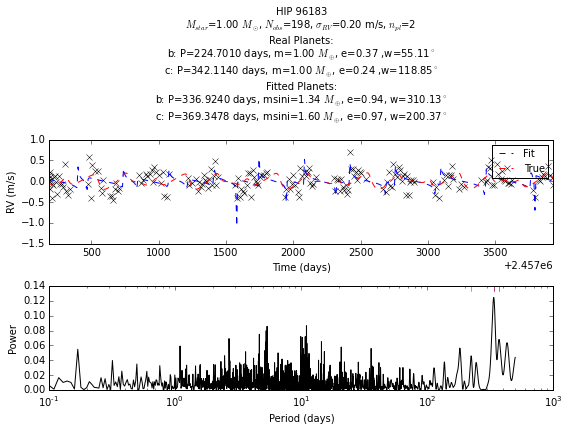

In [96]:
plt.close()
makePlot(sims[0])
plt.close()

In [97]:
# plt.close()
# star = sims[0].star
# makePhasePlot(star)
# plt.close()

In [98]:
# print medianSep(sims[0].planet.obsList)

In [99]:
# f=open('sim1.pckl','wb')
# star = sims[0]
# pickle.dump(star,f)
# f.close()


In [100]:
# f = open('sim1.pckl','r')
# star = pickle.load(f)


# # Saving the objects:
# with open('objs.pickle', 'w') as f:
#     pickle.dump([obj0, obj1, obj2], f)

# # Getting back the objects:
# with open('sim1.pckl') as f:
#     star = pickle.load(f)
